**Implement SeRes18 on Res18**

In [1]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct
from PIL import Image
import time
import shutil

%matplotlib inline
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm import *


First load the lookup tables from the CSV files (you don't need to do this if you just did all the steps from part 1).

In [2]:
train_offsets_df = pd.read_csv("train_offsets.csv", index_col=0)
train_images_df = pd.read_csv("train_images.csv", index_col=0)
val_images_df = pd.read_csv("val_images.csv", index_col=0)

c:\users\yang\anaconda3\envs\cdiscount\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import Dataset

In [4]:
class BSONIterator(Dataset):
    def __init__(self, bson_file, images_df, offsets_df, transform, lock, train=True):
        super(BSONIterator, self).__init__()
        self.file = bson_file
        self.images_df = images_df
        self.offsets_df = offsets_df
        self.transform = transform
        self.lock = lock
        self.train = train

    def __getitem__(self, idx):
        # Protect file and dataframe access with a lock.
        with self.lock:
            image_row = self.images_df.iloc[idx]
            product_id = image_row["product_id"]
            offset_row = self.offsets_df.loc[product_id]
            # Random access this product's data from the BSON file.
            self.file.seek(offset_row["offset"])
            item_data = self.file.read(offset_row["length"])
        # Grab the image from the product.
        item = bson.BSON.decode(item_data)
        img_idx = image_row["img_idx"]
        bson_img = item["imgs"][img_idx]["picture"]

        # Load the image.
        image = io.BytesIO(bson_img)
        img = Image.open(image)
        x = self.transform(img)
        if self.train:
            y = image_row["category_idx"]
            return x, y
        else:
            return x
    
    def __len__(self):
        return len(self.images_df)

In [5]:
data_dir = "./input/"
file_dir = r'C:\Users\YANG\Downloads\cdiscount'
train_bson_path = os.path.join(file_dir, "train.bson")
train_bson_file = open(train_bson_path, "rb")

In [6]:
import threading
lock = threading.Lock()

In [8]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transform_train = T.Compose([T.RandomHorizontalFlip(), 
                             T.ToTensor(),T.Normalize(mean=mean, std=std)])
transform_val = T.Compose([T.ToTensor(),T.Normalize(mean=mean, std=std)])

Create a generator for training and a generator for validation.

In [9]:
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df, transform_train, lock, train = True)
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df, transform_val, lock, train = True)

In [10]:
print(len(train_gen), len(val_gen))

989828 241932


In [11]:
batch_size = 256
loader_train = DataLoader(train_gen, batch_size=batch_size, 
                          sampler=sampler.RandomSampler(train_gen), num_workers=0, pin_memory = True)
loader_val = DataLoader(val_gen, batch_size=batch_size, 
                          sampler=sampler.RandomSampler(val_gen), num_workers=0, pin_memory = True)

# Part 3: Training

Create a Se-Resnet18 model and train it.

**SEResNet18**

In [13]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import math
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False) #No bias, due to use of BN layer?


class SEScale(nn.Module):
    """Squezee and Exicite here."""
    def __init__(self, channel, reduction=16):
        super(SEScale, self).__init__()
        self.fc1 = nn.Conv2d(channel, channel//reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(channel//reduction, channel, kernel_size=1)

    def forward(self, x):
        x = F.adaptive_avg_pool2d(x,1)
        x = self.fc1(x)
        x = F.relu(x, inplace=True)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x


class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, reduction = 16, stride=1, downsample=None):
        super(SEBasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride) #kernel_size = 1. H, W only changes once here.
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes) #stride and kernel_size default to 1, so no change in H, W.
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.scale = SEScale(planes, reduction)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x) #need to resize previous residual to current output

        out = self.scale(out)*out + residual #SEScale and broadcasting
        out = self.relu(out)

        return out


class SEBottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, reduction = 16, stride=1, downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False) #bottleneck, squeeze here. stride = 1, no change in H, W.
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False) #H, W only changes once here., (kernel_size, padding): (3, 1) = (1, 0).
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False) #bottleneck, expand here. stride = 1 , no change in H, W.
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.scale = self.SEScale(planes * 4, reduction)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x) #need to resize previous residual to current output

        out = self.scale(out)*out + residual #SEScale and broadcasting
        out = self.relu(out)

        return out


class SEResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, reduction = 16):
        self.inplanes = 64
        super(SEResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], reduction=4)
        self.layer2 = self._make_layer(block, 128, layers[1], reduction=8, stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], reduction=reduction, stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], reduction=reduction, stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def load_pretrain_dict(self, pretrain_state_dict, skip=['fc.weight'	,'fc.bias']):
        state_dict = self.state_dict()
        for key in pretrain_state_dict:
            if key in skip: continue
            state_dict[key] = pretrain_state_dict[key]
        self.load_state_dict(state_dict)
        
    def _make_layer(self, block, planes, blocks, reduction = 16, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False), #(kernel_size, padding): (3, 1) = (1, 0).
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, reduction, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, reduction))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def seresnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SEResNet(SEBasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_pretrain_dict(model_zoo.load_url(model_urls['resnet18']))
    return model



def seresnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SEResNet(SEBasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model



def seresnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SEResNet(SEBottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model



def seresnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SEResNet(SEBottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model



def seresnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SEResNet(SEBottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model


In [14]:
model = seresnet18(pretrained=True) #load the pretained models though SE modules/layers are just random.
model.avgpool = nn.AvgPool2d(kernel_size = 6)
model.fc = nn.Linear(in_features=512, out_features=5270) #or 49 + 483 + 5270

In [15]:
model.layer1 #check the module

Sequential (
  (0): SEBasicBlock (
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (scale): SEScale (
      (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (1): SEBasicBlock (
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (scale): SEScale (
      (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (fc2): Conv2d(

In [16]:
for param in model.parameters(): #Freeze all modules first
    param.requires_grad = False
    
for sequence in [model.layer1, model.layer2, model.layer3, model.layer4]: #Free all SE modules
    for layer in sequence:
        for param in layer.scale.parameters():
            param.requires_grad = True
            
for param in model.fc.parameters():#Free last fc layer
    param.requires_grad = True

**ResNet50**

In [17]:
# model = torchvision.models.resnet50(pretrained=True)
# model.avgpool = nn.AvgPool2d(kernel_size = 5)
# model.fc = nn.Linear(in_features=2048, out_features=5270) #or 49 + 483 + 5270

In [18]:
init.kaiming_normal(model.fc.weight.data) #initialize with He norm.
model.fc.bias.data.zero_()
model.cuda()


SEResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): SEBasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (scale): SEScale (
        (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): SEBasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, mome

In [19]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(lr, optimizer, epoch, denominator = 2):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr * (0.1 ** (epoch // denominator))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    batch_size = target.size(0)
    _, pred = output.max(dim=1)
    correct = pred.eq(target)
    res = []
    for k in topk:
        correct_k = correct.float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [20]:
def train(train_loader, model, criterion, optimizer, epoch, print_freq = 50):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    loss_log = []
    acc_log = []

    # switch to train mode
    model.train()

    end = time.time()
    for i, (img, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda(async=True)
        img = img.cuda(async=True)
        img_var = Variable(img)
        target_var = Variable(target)

        # compute output
        output = model(img_var)
        loss = criterion(output, target_var)
        loss_log.append(loss)
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1, ))[0]#only need top1
        losses.update(loss.data[0], img.size(0)) #[0] to take out the float inside torch.Tensor
        top1.update(prec1[0], img.size(0))
        acc_log.append(top1.val)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1))
    return loss_log, acc_log

In [21]:
def validate(val_loader, model, print_freq=50):
    batch_time = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (img, target) in enumerate(val_loader):
        
        target = target.cuda(async=True)
        img = img.cuda(async=True)
        img_var = Variable(img, volatile=True)
        target_var = Variable(target, volatile=True)

        # compute output
        output = model(img_var)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]#only need top1
        top1.update(prec1[0], img.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'.format(top1=top1))

    return top1.avg

In [26]:
def main():
    best_prec1 = 45
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr = 1e-2, momentum=0.9, 
                          weight_decay=0)
    resume = None
    start_epoch = 0
    epochs = 1
    arch = 'resnet18'

    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))

    for epoch in range(start_epoch, epochs):
        
        #every 2 epochs adjust lr by 10 times.
        adjust_learning_rate(lr=1e-3, optimizer=optimizer, epoch=epoch, denominator=2)

        # train for one epoch
        loss_log, acc_log = train(train_loader=loader_train, model=model, criterion=criterion,
                                  optimizer=optimizer, epoch=epoch)

        # evaluate on validation set
        prec1 = validate(val_loader=loader_val, model=model)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': arch,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
        }, is_best)

        #plot loss and acc
        fig = plt.figure(figsize = (6,3), dpi = 1200)
        loss_log = np.array(list(map(lambda x: x.data[0], loss_log)))
        ax1 = plt.subplot(121)
        ax1.plot(loss_log)
        ax1.set_ylabel('Loss', weight = 'bold')
        acc_log = np.array(acc_log)
        ax2 = plt.subplot(122)
        ax2.plot(acc_log)
        ax2.set_ylabel('Train_accuracy', weight = 'bold')
        np.savetxt(X=np.vstack((loss_log, acc_log)), fname='loss_acc_log.txt', fmt='%.3f')

Epoch: [0][0/3867]	Time 0.511 (0.511)	Data 0.358 (0.358)	Loss 3.5805 (3.5805)	Prec@1 41.406 (41.406)
Epoch: [0][50/3867]	Time 0.460 (0.478)	Data 0.324 (0.330)	Loss 3.9493 (3.7044)	Prec@1 36.719 (38.228)
Epoch: [0][100/3867]	Time 0.455 (0.475)	Data 0.309 (0.329)	Loss 3.8292 (3.6804)	Prec@1 37.500 (38.513)
Epoch: [0][150/3867]	Time 0.482 (0.468)	Data 0.347 (0.322)	Loss 3.9572 (3.6942)	Prec@1 37.891 (38.411)
Epoch: [0][200/3867]	Time 0.458 (0.465)	Data 0.308 (0.319)	Loss 3.4331 (3.7080)	Prec@1 42.188 (38.318)
Epoch: [0][250/3867]	Time 0.445 (0.463)	Data 0.310 (0.317)	Loss 3.4957 (3.7096)	Prec@1 39.453 (38.191)
Epoch: [0][300/3867]	Time 0.456 (0.461)	Data 0.308 (0.316)	Loss 3.8856 (3.7018)	Prec@1 34.375 (38.290)
Epoch: [0][350/3867]	Time 0.455 (0.460)	Data 0.308 (0.315)	Loss 3.9614 (3.7044)	Prec@1 35.938 (38.174)
Epoch: [0][400/3867]	Time 0.448 (0.460)	Data 0.313 (0.314)	Loss 3.7989 (3.7057)	Prec@1 39.844 (38.175)
Epoch: [0][450/3867]	Time 0.448 (0.460)	Data 0.313 (0.314)	Loss 3.7525 (3.70

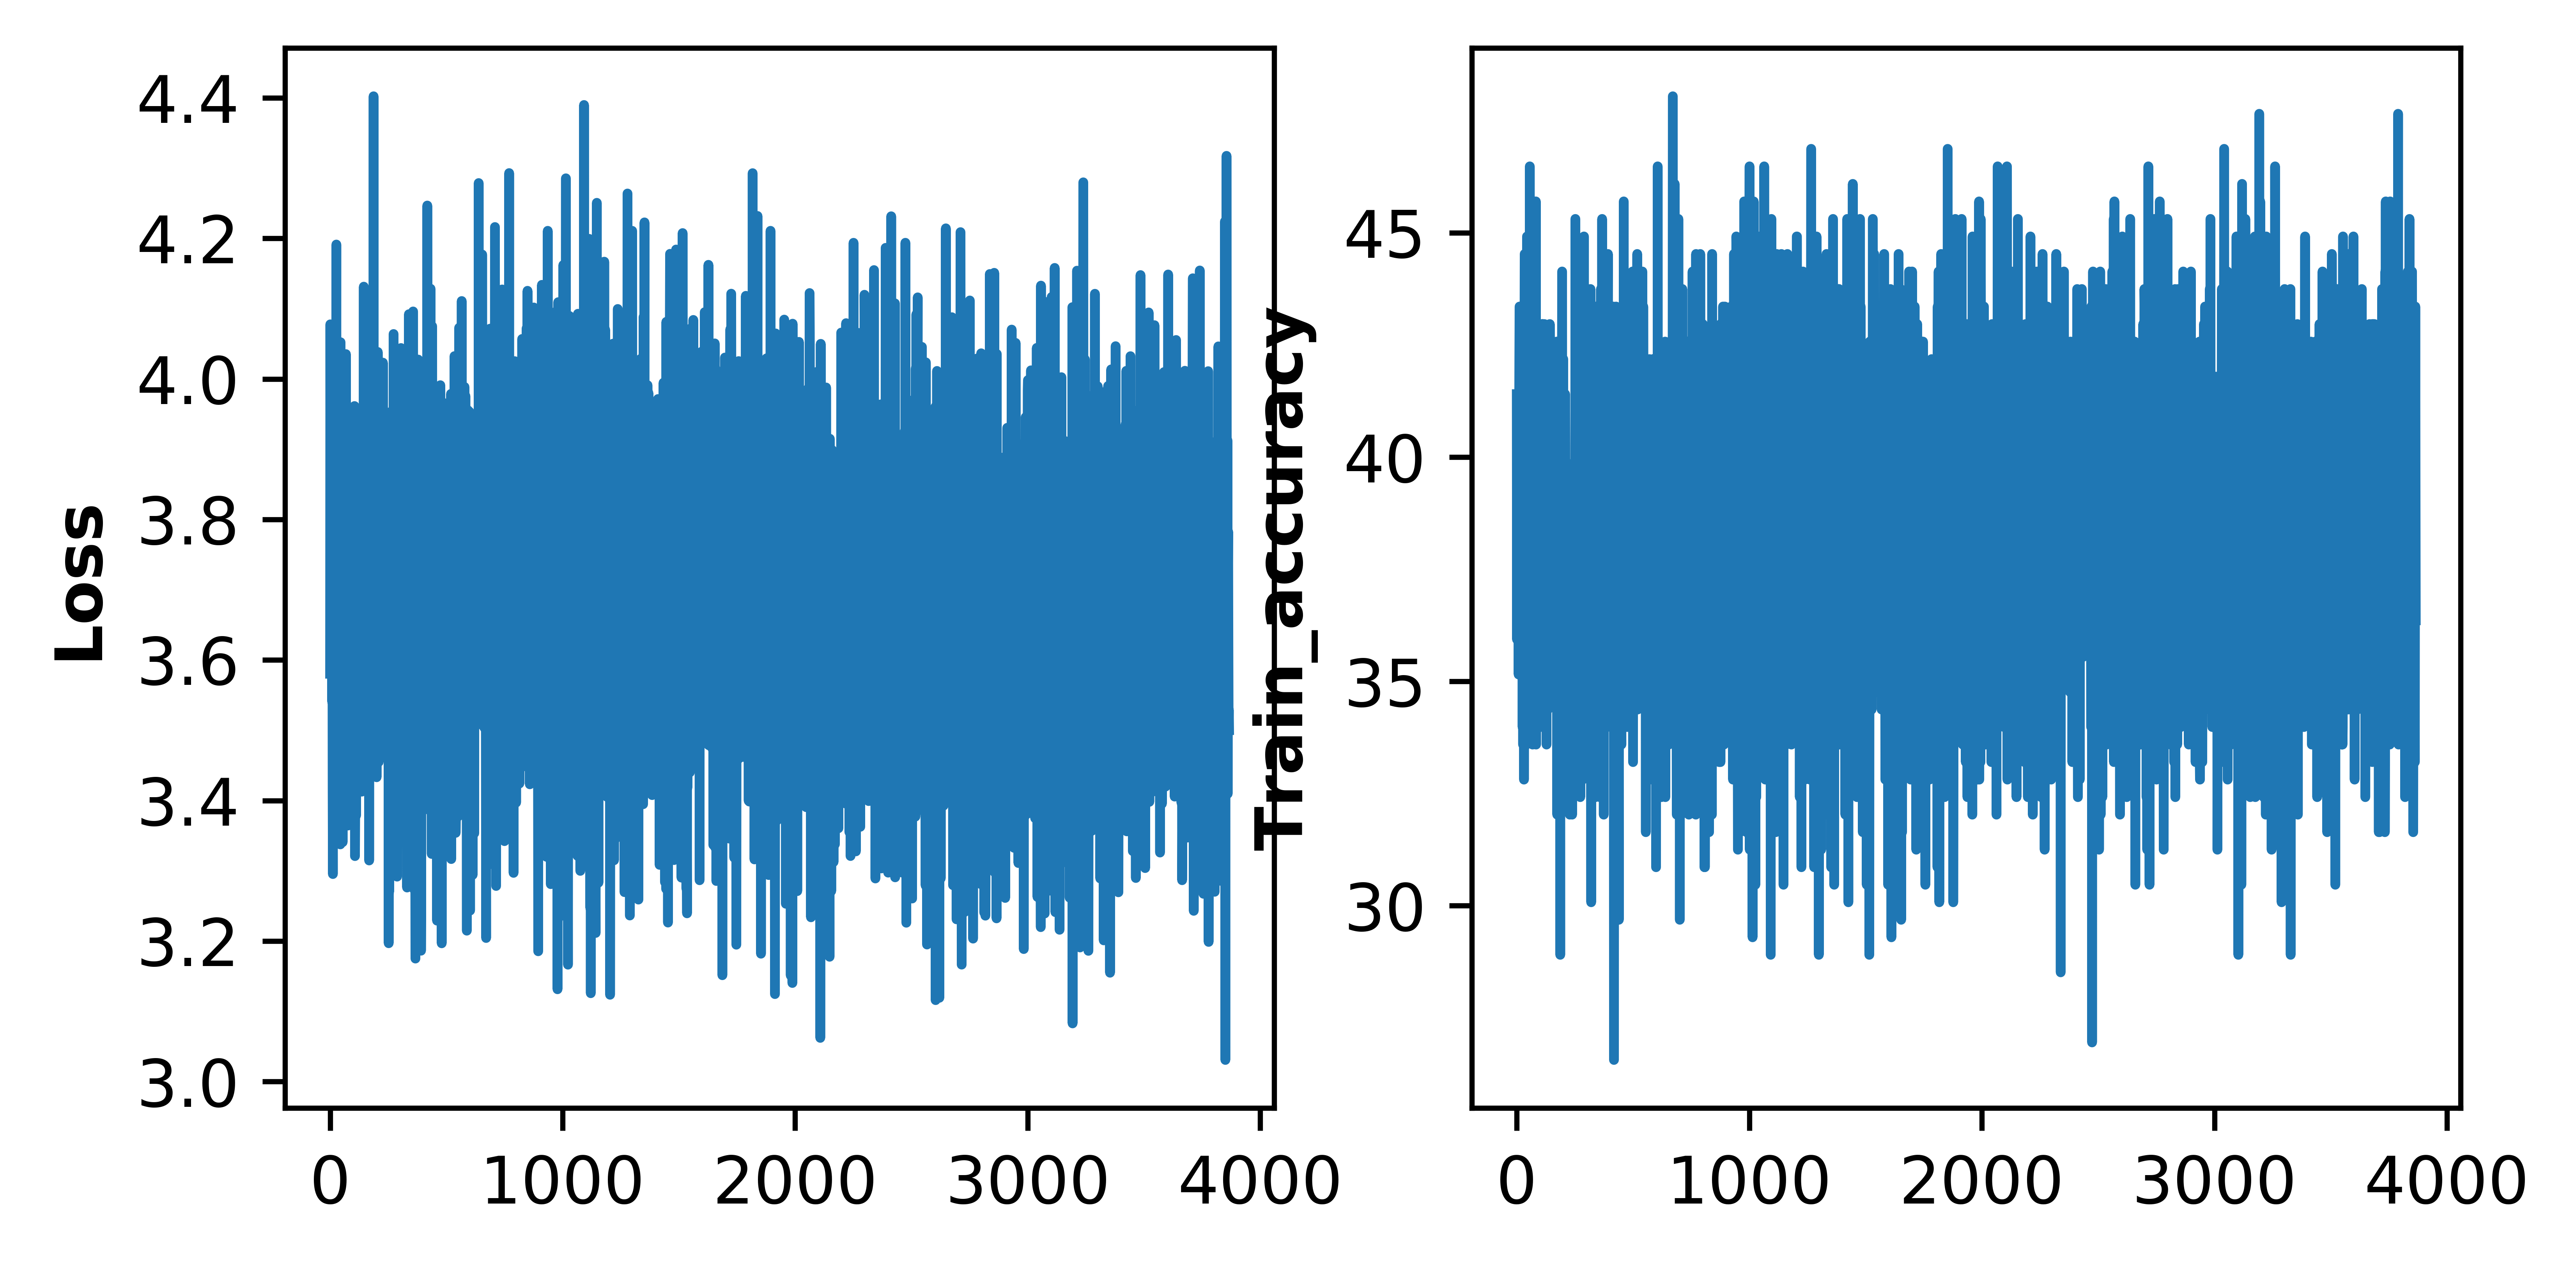

In [27]:
main()